# Bottlenecking

## 1. Setup and configuration

In [1]:
# Necessary imports
import numpy  as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from scipy.misc import imresize
from keras import optimizers
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
# Seed for reproducibility
np.random.seed(0)

In [4]:
# Local data paths
TRAIN_PATH = "../../../../data/wiki_folds/gender/train_1.csv"
VALID_PATH = "../../../../data/wiki_folds/gender/valid_1.csv"
IMG_PATH  = "../../../../data/wiki/%s"

In [5]:
# Image dimensions and num epochs
IMG_WIDTH  = 224
IMG_HEIGHT = 224
IMG_DIMS = (IMG_WIDTH,IMG_HEIGHT)

# VGG16-Face Pre-trained weights download links
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
VGG16_LOCAL_W   = "'vgg16_weights_tf_dim_ordering_tf_kernels.h5'"

In [6]:
# Experiment config
NUM_EPOCHS     = 500
BATCH_SIZE     = 32
TARGET_FEATURE = "age"

## 2. Loading the data

In [7]:
# Read training and validation sets of this fold
train = pd.read_csv(TRAIN_PATH)
valid = pd.read_csv(VALID_PATH)

# Drop unecessary columns
train = train[["full_path","gender","age"]]
valid = valid[["full_path","gender","age"]]

In [8]:
# Setting data path to be relative to the current directory
true_path = lambda x: IMG_PATH % x
train["full_path"] = train["full_path"].apply(lambda x: true_path(x))
valid["full_path"] = valid["full_path"].apply(lambda x: true_path(x))

In [9]:
# Preview training set
train.head()

,full_path,gender,age
0,../../../../data/wiki/79/3781079_1888-02-15_19...,1.0,93
1,../../../../data/wiki/72/8801772_1950-11-09_20...,1.0,62
2,../../../../data/wiki/10/33256210_1979-04-06_2...,1.0,33
3,../../../../data/wiki/07/14853007_1984-05-07_2...,0.0,23
4,../../../../data/wiki/27/11914827_1986-05-21_2...,1.0,28


In [10]:
# Preview validation set
valid.head()

,full_path,gender,age
0,../../../../data/wiki/17/8740317_1961-08-29_20...,1.0,48
1,../../../../data/wiki/40/31819740_1984-10-18_2...,1.0,30
2,../../../../data/wiki/81/32702381_1929-02-17_1...,1.0,27
3,../../../../data/wiki/69/43906569_1930-04-24_1...,1.0,22
4,../../../../data/wiki/69/16116069_1942-04-20_2...,0.0,69


## 3. Declaring the network

In [11]:
# VGG16 network
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(IMG_WIDTH, IMG_HEIGHT,3)))

model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

In [12]:
model.add(Flatten())
model.add(Dense(4096, activation='relu', name="fc_1"))
model.add(Dense(4096, activation='relu', name="fc_w"))
model.add(Dense(1000, activation='softmax',  name="predictions"))

In [13]:
# Obtain VGG16-Face weights
weights_path = get_file(VGG16_LOCAL_W,TF_WEIGHTS_PATH, cache_subdir='models')

In [14]:
# Loading VGG16-Face weights to VGG16 network
model.load_weights(weights_path)

In [15]:
model.layers.pop()
model.add(Dense(500))
model.add(Dense(100))
model.add(Dense(1))

In [16]:
# Compile
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

## 4. Setting up the training pipeline

In [17]:
# Handy utility to read the image raw data from its ath
def get_image(x):
    try:
        val = img_to_array(imresize(load_img(x),IMG_DIMS))
    except:
        val = "ERR"
    return val

In [18]:
# Data generator
def generate_data(df, batch_size, target_feature):
    start, end = 0, batch_size
    while True:
        data   = df.sample(frac=1).reset_index(drop=True)
        sample = data[start:end]
        
        X         = pd.DataFrame(sample["full_path"].apply(lambda x:get_image(x)))
        good_rows = X["full_path"] != "ERR"
        X         = X[good_rows]
        X.reset_index(inplace=True)
        X = X["full_path"].apply(lambda x: x.reshape((1,)+ x.shape))
        X = np.vstack(X)
        #X = model.predict(X, X.shape[0])
        
        Y = sample[good_rows]
        Y = Y[target_feature].as_matrix()
        yield (X,Y)

In [19]:
train_gen = generate_data(train, BATCH_SIZE, TARGET_FEATURE)
valid_gen = generate_data(valid, BATCH_SIZE, TARGET_FEATURE)

In [20]:
X,Y = train_gen.next()

/usr/local/lib/python2.7/dist-packages/pandas/core/ops.py:739: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = lib.scalar_compare(x, y, op)


In [21]:
X.shape

(32, 224, 224, 3)

In [22]:
Y.shape

(32,)

In [23]:
for layer in model.layers[:len(model.layers)-3]:
    layer.trainable = False

In [24]:
# Train
history = model.fit_generator(train_gen, 
                              validation_data=valid_gen,
                              nb_val_samples=BATCH_SIZE,
                              samples_per_epoch=BATCH_SIZE, 
                              nb_epoch=NUM_EPOCHS)

Epoch 1/500
32/32 [==============================] - 12s - loss: 1583.4062 - mean_squared_error: 1583.4062 - val_loss: 1411.7448 - val_mean_squared_error: 1411.7448
Epoch 2/500
32/32 [==============================] - 2s - loss: 1769.2339 - mean_squared_error: 1769.2339 - val_loss: 1559.0630 - val_mean_squared_error: 1559.0630
Epoch 3/500
32/32 [==============================] - 2s - loss: 2002.3257 - mean_squared_error: 2002.3257 - val_loss: 2067.1177 - val_mean_squared_error: 2067.1177
Epoch 4/500
32/32 [==============================] - 2s - loss: 1494.1991 - mean_squared_error: 1494.1991 - val_loss: 1795.8787 - val_mean_squared_error: 1795.8787
Epoch 5/500
32/32 [==============================] - 2s - loss: 1581.4877 - mean_squared_error: 1581.4877 - val_loss: 1678.8506 - val_mean_squared_error: 1678.8506
Epoch 6/500
32/32 [==============================] - 2s - loss: 1844.2502 - mean_squared_error: 1844.2502 - val_loss: 1264.7854 - val_mean_squared_error: 1264.7854
Epoch 7/500
32/

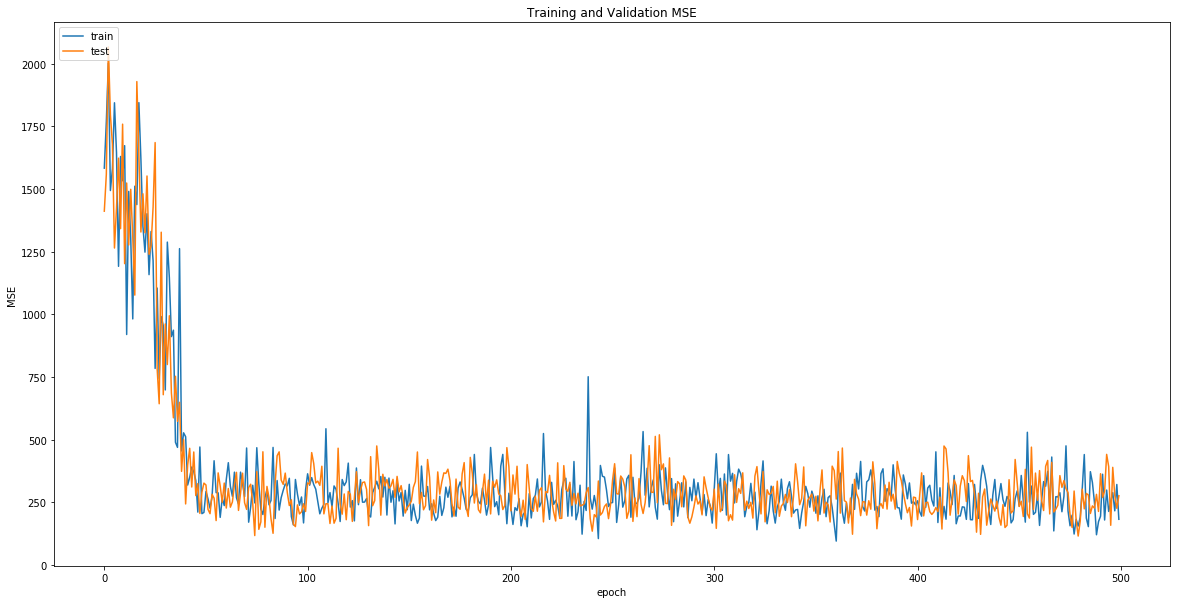

In [25]:
 # Plotting training accuracy and testing accuracy acros epochs
plt.figure(figsize=(20,10))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Training and Validation MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# serialize model to JSON
model_json = model.to_json()
with open("model_ba.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_ba.h5")
print("Saved model to disk")

Saved model to disk


In [27]:
#Binary data
np.save("yaya.npy", history.history["mean_squared_error"])
np.savetxt("yaya.txt", history.history["val_mean_squared_error"])
